In [2]:
import os
import time
import joblib
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.preprocessing import LabelEncoder, label_binarize
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, confusion_matrix, roc_auc_score

In [3]:
# Cargar datos (asume df con columnas: 'ID','Category','clean_resume' o 'Resume_str')
df = pd.read_csv("resume_clean.csv")  # o el csv que tengas
df = df.dropna(subset=['Category'])   # asegurar etiquetas
texts = df['clean_resume'].fillna(df['Resume_str']).astype(str)  # preferencia por clean_resume
labels = df['Category'].astype(str)

# Encode labels
le = LabelEncoder()
y = le.fit_transform(labels)
class_names = le.classes_
n_classes = len(class_names)
print("Clases:", n_classes, class_names)

# Stratified split: train (70), val (15), test (15)
X_temp, X_test, y_temp, y_test = train_test_split(texts, y, test_size=0.15, stratify=y, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_temp, y_temp, test_size=0.17647, stratify=y_temp, random_state=42)
# note: 0.17647 * 0.85 ≈ 0.15 -> yields 70/15/15

print("Tamaños: train", len(X_train), "val", len(X_val), "test", len(X_test))

Clases: 24 ['ACCOUNTANT' 'ADVOCATE' 'AGRICULTURE' 'APPAREL' 'ARTS' 'AUTOMOBILE'
 'AVIATION' 'BANKING' 'BPO' 'BUSINESS-DEVELOPMENT' 'CHEF' 'CONSTRUCTION'
 'CONSULTANT' 'DESIGNER' 'DIGITAL-MEDIA' 'ENGINEERING' 'FINANCE' 'FITNESS'
 'HEALTHCARE' 'HR' 'INFORMATION-TECHNOLOGY' 'PUBLIC-RELATIONS' 'SALES'
 'TEACHER']
Tamaños: train 1738 val 373 test 373


In [4]:
def classification_report_multi(y_true, y_pred, labels=None, average='macro'):
    acc = accuracy_score(y_true, y_pred)
    prec, rec, f1, _ = precision_recall_fscore_support(y_true, y_pred, average=average, zero_division=0)
    cm = confusion_matrix(y_true, y_pred)
    return {"accuracy": acc, "precision": prec, "recall": rec, "f1": f1, "confusion_matrix": cm}

def print_report(name, report, label_encoder=None):
    print(f"=== {name} ===")
    print(f"Accuracy: {report['accuracy']:.4f}")
    print(f"Precision (macro): {report['precision']:.4f}")
    print(f"Recall (macro): {report['recall']:.4f}")
    print(f"F1 (macro): {report['f1']:.4f}")
    print("Confusion matrix shape:", report['confusion_matrix'].shape)
    print()


## Implementación del Modelo

In [7]:
from sklearn.feature_extraction.text import TfidfVectorizer
from xgboost import XGBClassifier

# TF-IDF
tfidf = TfidfVectorizer(max_features=50000, ngram_range=(1,2), min_df=3)
X_train_tfidf = tfidf.fit_transform(X_train)
X_val_tfidf = tfidf.transform(X_val)
X_test_tfidf = tfidf.transform(X_test)

# XGBoost classifier (CPU settings). 
# Si luego ejecutas en GPU cambias tree_method='gpu_hist', predictor='gpu_predictor', gpu_id=0
xgb = XGBClassifier(
    objective='multi:softprob',
    num_class=n_classes,
    n_estimators=300,
    max_depth=6,
    learning_rate=0.1,
    tree_method='hist',   # 'hist' para CPU; cambiar a 'gpu_hist' en Colab GPU
    use_label_encoder=False,
    eval_metric='mlogloss',
    random_state=42,
    verbosity=1
)

# Entrenamiento con early stopping (usando validación)
start = time.time()
xgb.fit(
    X_train_tfidf, y_train,
    eval_set=[(X_val_tfidf, y_val)],
    verbose=True
)
elapsed = time.time() - start
print("Tiempo training XGBoost (s):", elapsed)

# Guardar artefactos
os.makedirs("artifacts", exist_ok=True)
joblib.dump(tfidf, "artifacts/tfidf_vectorizer.joblib")
xgb.save_model("artifacts/xgb_model.json")


c:\Users\TAWTOCA\anaconda3\envs\machine\lib\site-packages\xgboost\training.py:183: UserWarning: [21:33:33] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[0]	validation_0-mlogloss:2.60419
[1]	validation_0-mlogloss:2.30737
[2]	validation_0-mlogloss:2.10351
[3]	validation_0-mlogloss:1.94830
[4]	validation_0-mlogloss:1.81214
[5]	validation_0-mlogloss:1.70226
[6]	validation_0-mlogloss:1.61337
[7]	validation_0-mlogloss:1.53138
[8]	validation_0-mlogloss:1.45995
[9]	validation_0-mlogloss:1.39895
[10]	validation_0-mlogloss:1.34058
[11]	validation_0-mlogloss:1.28770
[12]	validation_0-mlogloss:1.24344
[13]	validation_0-mlogloss:1.19814
[14]	validation_0-mlogloss:1.15771
[15]	validation_0-mlogloss:1.12223
[16]	validation_0-mlogloss:1.09101
[17]	validation_0-mlogloss:1.05966
[18]	validation_0-mlogloss:1.03338
[19]	validation_0-mlogloss:1.00707
[20]	validation_0-mlogloss:0.98388
[21]	validation_0-mlogloss:0.96276
[22]	validation_0-mlogloss:0.94330
[23]	validation_0-mlogloss:0.92549
[24]	validation_0-mlogloss:0.90526
[25]	validation_0-mlogloss:0.88983
[26]	validation_0-mlogloss:0.87708
[27]	validation_0-mlogloss:0.86458
[28]	validation_0-mlogloss:0.8

=== XGBoost VALIDATION ===
Accuracy: 0.7962
Precision (macro): 0.7639
Recall (macro): 0.7609
F1 (macro): 0.7556
Confusion matrix shape: (24, 24)

=== XGBoost TEST ===
Accuracy: 0.7694
Precision (macro): 0.7969
Recall (macro): 0.7286
F1 (macro): 0.7351
Confusion matrix shape: (24, 24)



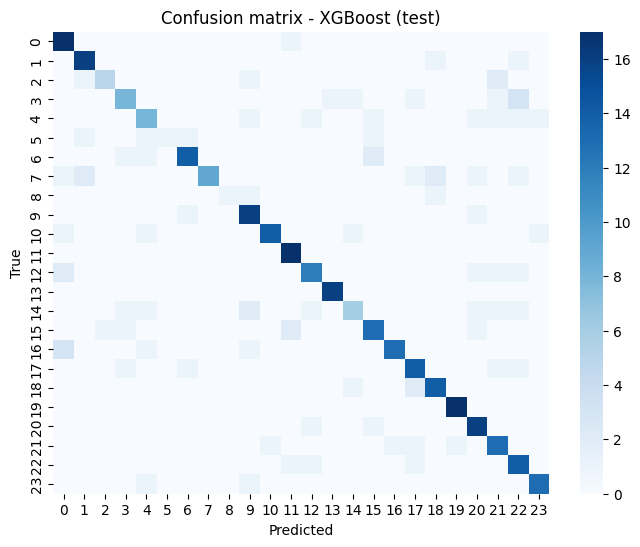

ROC-AUC (macro, ovr): 0.981145858897238


In [8]:
# Predicciones
y_val_pred = xgb.predict(X_val_tfidf)
y_test_pred = xgb.predict(X_test_tfidf)

# Reportes
rep_val = classification_report_multi(y_val, y_val_pred)
rep_test = classification_report_multi(y_test, y_test_pred)

print_report("XGBoost VALIDATION", rep_val)
print_report("XGBoost TEST", rep_test)

# Matriz de confusión (test)
import seaborn as sns
import matplotlib.pyplot as plt
plt.figure(figsize=(8,6))
sns.heatmap(rep_test['confusion_matrix'], annot=False, fmt='d', cmap='Blues')
plt.title('Confusion matrix - XGBoost (test)')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

# ROC-AUC multiclasificación (one-vs-rest) - requiere probabilidades y binarizado
y_test_proba = xgb.predict_proba(X_test_tfidf)
y_test_binarized = label_binarize(y_test, classes=np.arange(n_classes))

try:
    roc_auc = roc_auc_score(y_test_binarized, y_test_proba, average='macro', multi_class='ovr')
    print("ROC-AUC (macro, ovr):", roc_auc)
except Exception as e:
    print("ROC-AUC no pudo calcularse:", e)
